# Testing Metrics.py scripts from Vogt-Vincent 2024
This is a tool devloped by Noam Vogt-Vincent in paper *coral reef potential connectivity in the southwest Indian Ocean* (2024) to process key metrics
- Dispersal entropy
- Dispersal strength
- Dispersal stability 
- Centrality

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Process, plot and export key metrics:
    1. Dispersal entropy
    2. Dispersal strength
    3. Dispersal stability
    7. Centrality
@author: Noam Vogt-Vincent
"""

'\nProcess, plot and export key metrics:\n    1. Dispersal entropy\n    2. Dispersal strength\n    3. Dispersal stability\n    7. Centrality\n@author: Noam Vogt-Vincent\n'

## 1. Import pacakges 

In [2]:
# Avoid importing cmasher, and networkx for now
# In SECow, change ErrorCode to StatusCode, avoid importig numba for now 
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import cmasher as cmr
import cartopy.crs as ccrs
import networkx as nx
import sys
sys.path.insert(0, '../VogtVincent/SIM/')
from SECoW import Matrix
from matplotlib.gridspec import GridSpec
from tqdm import tqdm

#### Workflow
- Parameter Setup
- Problem Setup
- Grouping cells
- Processing Entropy
    - skip median daily entropy for storage purposes
    

In [3]:
###############################################################################
# PARAMETERS ##################################################################
###############################################################################

bio_code = sys.argv[1]

# BIOLOGY
spawning_months = [1, 2, 3, 10, 11, 12]  # Permitted spawning months

# PLOTTING
plot_full = True

# DIRECTORIES
dirs = {}
dirs['root'] = os.getcwd() + '/../'
dirs['matrix'] = dirs['root'] + 'MATRICES/'
dirs['ref'] = dirs['root'] + 'REFERENCE/'
dirs['grid'] = dirs['root'] + 'GRID_DATA/'
dirs['fig'] = dirs['root'] + 'FIGURES/'

# FILE-HANDLES
fh = {}
fh['flux_matrix'] = dirs['matrix'] + 'WINDS_flux_src_cell_' + bio_code + '.nc'
fh['flux_matrix_grp'] = dirs['matrix'] + 'WINDS_flux_src_grp_' + bio_code + '.nc'
fh['entropy_matrix'] = {'out': dirs['matrix'] + 'WINDS_src_ent_cell_' + bio_code + '.nc',
                        'in': dirs['matrix'] + 'WINDS_snk_ent_cell_' + bio_code + '.nc'}
fh['str_matrix'] = {'src': dirs['matrix'] + 'WINDS_src_str_cell_' + bio_code + '.nc',
                    'snk': dirs['matrix'] + 'WINDS_snk_str_cell_' + bio_code + '.nc'}
fh['coral'] = dirs['grid'] + 'coral_grid.nc'
fh['grid'] = dirs['grid'] + 'griddata_winds.nc'
fh['site_list'] = dirs['grid'] + 'site_reference_cell.csv'
fh['site_list_grp'] = dirs['grid'] + 'site_reference_grp.xlsx'
fh['sst'] = dirs['ref'] + 'SST/SECoW_SST.nc'

In [4]:
###############################################################################
# SET UP PROBLEM ##############################################################
###############################################################################

print('@>-------------------------<@')
print('........Preprocessing........')

# Load the flux matrix (required for several routines)
with xr.open_dataset(fh['flux_matrix']) as file:
    flux_obj = Matrix(file, bio_code)
    flux_obj.label(fh['site_list'])
    _flux = flux_obj.matrix.ns
    _flux = _flux[:, :, _flux.month.isin(spawning_months)].sum(dim='month')

    cell_list = flux_obj.matrix.source_cell.values

    # Precompute source- and sink-normalised forms
    src_flux = _flux/_flux.sum(dim='sink_cell')
    snk_flux = _flux/_flux.sum(dim='source_cell')
    _src_flux = src_flux.where(src_flux != 0).fillna(1.)
    _snk_flux = snk_flux.where(snk_flux != 0).fillna(1.)

    assert not np.isnan(src_flux).any()
    assert not np.isnan(snk_flux).any()
# Grouped form
with xr.open_dataset(fh['flux_matrix_grp'], chunks={'time': 1000}) as file:
    flux_obj_grp = Matrix(file, bio_code)
    flux_obj_grp.label(fh['site_list_grp'])
    _flux_grp = flux_obj_grp.matrix.ns
    _flux_grp = _flux_grp[:, :, _flux_grp.time.dt.month.isin(spawning_months)]

    _flux_grp_norm = _flux_grp.sum(dim='sink_group')
    _flux_grp_norm = _flux_grp_norm.where(_flux_grp_norm > 0).fillna(1)
    _flux_grp = (_flux_grp/_flux_grp_norm).compute() # Sink-normalised for all applications here

    _flux_grp_mean = (_flux_grp/_flux_grp.sum(dim='sink_group')).mean(dim='time').compute()

    grp_list = _flux_grp.source_group.values

def reorder(file):
    # Reorder and label matrices where necessary
    obj = Matrix(file, bio_code)
    obj.label(fh['site_list'])
    return obj.matrix

grid = xr.open_dataset(fh['coral'])
grid_data = xr.open_dataset(fh['grid'])

template_2d = np.nan*np.ones_like(grid.lsm_w.astype(np.float32))
template_3d = np.tile(np.nan*np.ones_like(grid.lsm_w.astype(np.float32))[:, :, np.newaxis], (1, 1, 2))

metrics = xr.Dataset(data_vars={# In/out entropy
                                'out_ent': (['lat', 'lon', 'mode'], template_3d.copy()),
                                'in_ent': (['lat', 'lon', 'mode'], template_3d.copy()),

                                # Out/In-strength
                                'out_str': (['lat', 'lon', 'mode'], template_3d.copy()),
                                'in_str': (['lat', 'lon', 'mode'], template_3d.copy()),

                                # Out/In consistency
                                'out_con': (['lat', 'lon'], template_2d.copy()),
                                'in_con': (['lat', 'lon'], template_2d.copy()),

                                # Betweenness centrality
                                'btw_cen': (['lat', 'lon', 'mode'], template_3d.copy())},

                     coords={'lon': (['lon'], grid.lon_rho_w.values),
                             'lon_bnd': (['lon_bnd'], np.concatenate([np.array([2*grid.lon_rho_w.values[0] -
                                                                                grid.lon_rho_w.values[1]]),
                                                                      grid.lon_rho_w.values,
                                                                      np.array([2*grid.lon_rho_w.values[-1] -
                                                                                grid.lon_rho_w.values[-2]])])),
                             'lat': (['lat'], grid.lat_rho_w.values),
                             'lat_bnd': (['lat_bnd'], np.concatenate([np.array([2*grid.lat_rho_w.values[0] -
                                                                                grid.lat_rho_w.values[1]]),
                                                                      grid.lat_rho_w.values,
                                                                      np.array([2*grid.lat_rho_w.values[-1] -
                                                                                grid.lat_rho_w.values[-2]])])),
                             'mode': (['mode'], ['day', 'full'])}
                     )

template_2d = np.nan*np.ones((len(cell_list)))
template_3d = np.nan*np.ones((len(cell_list), 2))

metrics_raw = xr.Dataset(data_vars={# In/out entropy
                                    'out_ent': (['cell', 'mode'], template_3d.copy()),
                                    'in_ent': (['cell', 'mode'], template_3d.copy()),

                                    # Out/In-strength
                                    'out_str': (['cell', 'mode'], template_3d.copy()),
                                    'in_str': (['cell', 'mode'], template_3d.copy()),

                                    # Out/In-consistency
                                    'out_con': (['cell'], template_2d.copy()),
                                    'in_con': (['cell'], template_2d.copy()),

                                    # Betweenness centrality
                                    'btw_cen': (['cell', 'mode'], template_3d.copy())},

                         coords={'cell': (['cell'], cell_list),
                                 'mode': (['mode'], ['day', 'full'])}
                         )

@>-------------------------<@
........Preprocessing........


/Users/jiaruizhou/.conda/envs/parcels_env/lib/python3.13/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1000. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)


# Notes to self:
- Had to add `.rename` in the end of assignment to match output dimension
- Delete median daily entropy computation 

In [15]:
###############################################################################
# ENTROPY #####################################################################
###############################################################################

print('......Computing entropy......')

# Compute the full entropy
metrics_raw.out_ent.loc[:, 'full'] = -(src_flux*np.log2(_src_flux)).sum(dim='sink_cell').rename({'source_cell': 'cell'})
metrics_raw.in_ent.loc[:, 'full'] = -(snk_flux*np.log2(_snk_flux)).sum(dim='source_cell').rename({'sink_cell': 'cell'})

# Compute median daily entropy
#with xr.open_dataset(fh['entropy_matrix']['out'], chunks={'source_cell': 1000}) as file:
    #file = reorder(file)
    #metrics_raw.out_ent.loc[:, 'day'] = file.entropy[:, file.time.dt.month.isin(spawning_months)].quantile(0.5, dim='time').compute()

#with xr.open_dataset(fh['entropy_matrix']['in'], chunks={'sink_cell': 1000}) as file:
    #file = reorder(file)
    #metrics_raw.in_ent.loc[:, 'day'] = file.entropy[:, file.time.dt.month.isin(spawning_months)].quantile(0.5, dim='time').compute()

......Computing entropy......


force break

In [9]:
###############################################################################
# STRENGTH ####################################################################
###############################################################################

print('.....Computing strength......')

with xr.open_dataset(fh['str_matrix']['src'] , chunks={'source_cell': 1000} ) as file:
    file = reorder(file)
    file = file.chunk({'time':-1})
    metrics_raw.out_str.loc[:, 'full'] = (file.ns/file.rc)[:, file.time.dt.month.isin(spawning_months)].mean(dim='time').compute().rename({'source_cell': 'cell'})
    metrics_raw.out_str.loc[:, 'day'] = (file.ns/file.rc)[:, file.time.dt.month.isin(spawning_months)].quantile(0.5, dim='time').compute().rename({'source_cell': 'cell'})

.....Computing strength......


/Users/jiaruizhou/.conda/envs/parcels_env/lib/python3.13/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "source_cell" starting at index 1000. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)


In [10]:
with xr.open_dataset(fh['str_matrix']['snk'], chunks={'sink_cell': 1000}) as file:
    file = reorder(file)
    file = file.chunk({'time':-1})
    metrics_raw.in_str.loc[:, 'full'] = (file.ns/file.rc)[:, file.time.dt.month.isin(spawning_months)].mean(dim='time').compute().rename({'sink_cell':'cell'})
    metrics_raw.in_str.loc[:, 'day'] = (file.ns/file.rc)[:, file.time.dt.month.isin(spawning_months)].quantile(0.5, dim='time').compute().rename({'sink_cell':'cell'})

/Users/jiaruizhou/.conda/envs/parcels_env/lib/python3.13/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "sink_cell" starting at index 1000. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)


In [11]:
###############################################################################
# consistency ####################################################################
###############################################################################

print('.....Computing consistency......')
with xr.open_dataset(fh['str_matrix']['src'], chunks={'source_cell': 1000}) as file:
    file = reorder(file)
    n_days = int(file.time.dt.month.isin(spawning_months).sum())
    metrics_raw.out_con.data = np.argmax((np.sort(file.ns[:, file.time.dt.month.isin(spawning_months)], axis=-1)[:, ::-1].cumsum(axis=-1)
                                          >= 0.5*file.ns[:, file.time.dt.month.isin(spawning_months)].sum(dim='time').values.reshape(-1, 1)), axis=-1)/n_days


with xr.open_dataset(fh['str_matrix']['snk'], chunks={'sink_cell': 1000}) as file:
    file = reorder(file)
    metrics_raw.in_con.data = np.argmax((np.sort(file.ns[:, file.time.dt.month.isin(spawning_months)], axis=-1)[:, ::-1].cumsum(axis=-1)
                                          >= 0.5*file.ns[:, file.time.dt.month.isin(spawning_months)].sum(dim='time').values.reshape(-1, 1)), axis=-1)/n_days

.....Computing consistency......


/Users/jiaruizhou/.conda/envs/parcels_env/lib/python3.13/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "source_cell" starting at index 1000. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/Users/jiaruizhou/.conda/envs/parcels_env/lib/python3.13/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "sink_cell" starting at index 1000. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)


In [ ]:
###############################################################################
# BETWEENNESS CENTRALITY ######################################################
###############################################################################

print('')
print('...Computing btw centrality..')
log_flux = -np.log10(_flux_grp_mean.where(_flux_grp_mean > 0).fillna(1e-20).values)
graph = nx.from_numpy_array(log_flux, create_using=nx.DiGraph)
graph = nx.relabel_nodes(graph, {i: int(grp_list[i]) for i in range(len(grp_list))})

btw_template = np.nan*xr.ones_like(metrics_raw.out_con)
btw_template = btw_template.assign_coords({'cell': np.floor(btw_template.cell/2**8).astype(int)})
_btw_cen_full = btw_template.copy()

# Mean picture
_btw_cen_full_ = nx.betweenness_centrality(graph, weight='weight')

for group in grp_list:
    _btw_cen_full.loc[group] = _btw_cen_full_[group]

metrics_raw.btw_cen.loc[:, 'full'] = _btw_cen_full.assign_coords({'cell': cell_list})

# Compute betweenness centrality across iterations, and take the median
n_its = 100
_btw_cen_day = xr.DataArray(data=np.nan*np.ones((len(cell_list), n_its)),
                           dims=['cell', 'iteration'],
                           coords={'cell': (['cell'], cell_list),
                                   'iteration': (['iteration'], np.arange(n_its))})
_btw_cen_day = _btw_cen_day.assign_coords({'cell': np.floor(_btw_cen_day.cell/2**8).astype(int)})

np.random.seed(1234)
random_slices = np.random.choice(np.arange(len(_flux_grp.time)), size=(n_its,))

for it in tqdm(range(n_its), total=n_its):
    submatrix = _flux_grp[:, :, random_slices[it]].drop('time')
    log_flux = -np.log10(submatrix.where(submatrix > 0).fillna(1e-20).values)
    graph = nx.from_numpy_array(log_flux, create_using=nx.DiGraph)
    graph = nx.relabel_nodes(graph, {i: int(grp_list[i]) for i in range(len(grp_list))})

    _btw_cen_day_ = nx.betweenness_centrality(graph, weight='weight')

    for group in grp_list:
        _btw_cen_day.loc[group, it] = _btw_cen_day_[group]

_btw_cen_day = _btw_cen_day.assign_coords({'cell': cell_list})
metrics_raw.btw_cen.loc[:, 'day'] = _btw_cen_day.median(dim='iteration')


...Computing btw centrality..


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1688184/1307772405.py:35: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  submatrix = _flux_grp[:, :, random_slices[it]].drop('time')
100%|██████████| 100/100 [02:45<00:00,  1.66s/it]


In [1]:
###############################################################################
# GRIDDING ####################################################################
###############################################################################

print('')
print('..........Gridding...........')

for idx in tqdm(cell_list, total=len(cell_list)):
    idx_loc = np.where(grid.reef_idx_w == idx)

    for metric in ['out_ent', 'in_ent', 'out_str', 'in_str', 'btw_cen']:
        for mode in ['day', 'full']:
            metrics[metric].loc[:, :, mode][idx_loc] = metrics_raw[metric].loc[idx, mode]

    for metric in ['out_con', 'in_con']:
        metrics[metric][idx_loc] = metrics_raw[metric].loc[idx]

print('')


..........Gridding...........


NameError: name 'tqdm' is not defined

# Notes to self:
- Gridding is done but variable creation is not good
- RuntimeError: NetCDF: Filter error: bad id or parameters or duplicate filter: (variable 'mode', group '/')
- Troubleshoot: The corrdinate variables shouldn't be compressed so modify the encoding to only compress the data variables
- WORKED!

In [21]:
encoding = {var:{'zlib':True,'complevel':5}
           for var in metrics_raw.data_vars}

metrics.to_netcdf(dirs['ref'] + 'Metrics/' + bio_code + '_gridded_metrics.nc', encoding=encoding)
metrics_raw.to_netcdf(dirs['ref'] + 'Metrics/' + bio_code + '_metrics.nc', encoding=encoding)

@>-------------------------<@
...........Plotting..........


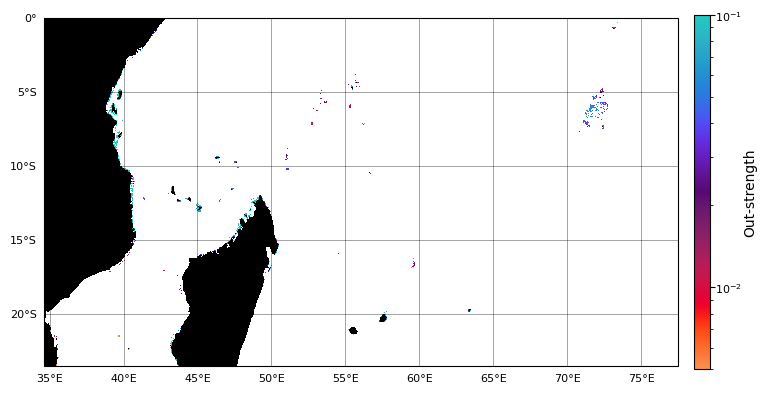

IndexError: index 6 is out of bounds for axis 0 with size 1

In [30]:
###############################################################################
# PLOTTING ####################################################################
###############################################################################

print('@>-------------------------<@')
print('...........Plotting..........')

# Set up grids
lon_bnd = grid.lon_psi_w.values
dlon = np.ediff1d(lon_bnd[:2])
lon_bnd = np.concatenate([lon_bnd[0]-dlon, lon_bnd, lon_bnd[-1]+dlon])

lat_bnd = grid.lat_psi_w.values
dlat = np.ediff1d(lat_bnd[:2])
lat_bnd = np.concatenate([lat_bnd[0]-dlat, lat_bnd, lat_bnd[-1]+dlat])

def plot_overview(matrix, vmin, vmax, log, label, fh, cmap):
    f = plt.figure(figsize=(8.6, 4.6))
    gs = GridSpec(1, 2, figure=f, width_ratios=[1.0, 0.025], wspace=0.05, hspace=0.04)
    ax = []
    ax.append(f.add_subplot(gs[0, 0], projection = ccrs.PlateCarree()))   # Overview
    ax.append(f.add_subplot(gs[0, 1]))   # cbar

    gl = []
    reef_plots = []

    # Create the overview plot first
    ax[0].pcolormesh(lon_bnd, lat_bnd, grid.lsm_w.where(grid.lsm_w == 1),
                      vmin=0, vmax=1, cmap=cmr.neutral_r, rasterized=True, zorder=5)
    if log:
        reef_plots.append(ax[0].pcolormesh(lon_bnd, lat_bnd, matrix,
                                           norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                                           cmap=cmap, zorder=2))
    else:
        reef_plots.append(ax[0].pcolormesh(lon_bnd, lat_bnd, matrix,
                                           vmin=vmin, vmax=vmax,
                                           cmap=cmap, zorder=2))

    gl.append(ax[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=0.5, color='k', linestyle='-',
                              alpha=0.5, zorder=4))
    gl[0].xlocator = mticker.FixedLocator(np.arange(-210, 210, 5))
    gl[0].ylocator = mticker.FixedLocator(np.arange(-90, 120, 5))
    gl[0].top_labels = False
    gl[0].right_labels = False
    gl[0].ylabel_style = {'size': 8}
    gl[0].xlabel_style = {'size': 8}

    # Background colour key
    cbar = plt.colorbar(reef_plots[0], cax=ax[1], orientation='vertical')
    ax[1].tick_params(axis='y', labelsize=8, pad=0.01)
    cbar.set_label(label, size=10, labelpad=1)

    plt.savefig(dirs['fig'] + 'Metrics/Overview/' + bio_code + '/' + bio_code + '_' + fh + '.png', bbox_inches='tight', dpi=1200)
    plt.show()

#def plot_close(matrix, vmin, vmax, log, label, fh, cmap):
    #f = plt.figure(figsize=(8.0, 9.2))
    #gs = GridSpec(9, 3, figure=f, width_ratios=[0.42, 1.0, 0.53],
    #              height_ratios=[0.41, 0.04, 0.19, 0.04, 0.308, 0.04, 0.308, 0.04, 0.03], wspace=0.22, hspace=0.05)
    #ax = []
    #ax.append(f.add_subplot(gs[0:3, 0], projection = ccrs.PlateCarree())) # EACC1
    #ax.append(f.add_subplot(gs[0, 1], projection = ccrs.PlateCarree()))   # Seychelles (inner)
    #ax.append(f.add_subplot(gs[2, 1], projection = ccrs.PlateCarree()))   # Seychelles (outer)
    #ax.append(f.add_subplot(gs[0:3, 2], projection = ccrs.PlateCarree())) # Chagos
    #ax.append(f.add_subplot(gs[4:7, 0], projection = ccrs.PlateCarree())) # EACC2
    #ax.append(f.add_subplot(gs[4, 1], projection = ccrs.PlateCarree()))   # Comoros
    #ax.append(f.add_subplot(gs[4, 2], projection = ccrs.PlateCarree()))   # N Madagascar
    #ax.append(f.add_subplot(gs[6, 1], projection = ccrs.PlateCarree()))   # Reunion/Mauritius
    #ax.append(f.add_subplot(gs[6, 2], projection = ccrs.PlateCarree()))   # S Madagascar
    #ax.append(f.add_subplot(gs[8, :]))                                    # CBAR

    # Plot data
    gl = []
    reef_plots = []

    # Add elements to each panel
    for i in range(9):
        ax[i].contourf(grid_data.lon_rho, grid_data.lat_rho, grid_data.h, levels=np.arange(0, 6000, step=250),
                       cmap=cmr.get_sub_cmap(cmr.ocean_r, 0, 0.6), zorder=0)
        ax[i].pcolormesh(lon_bnd, lat_bnd, 1 - grid.lsm_w.where(grid.lsm_w == 1),
                         vmin=0, vmax=1, cmap=cmr.neutral, rasterized=True, zorder=5)
        if log:
            reef_plots.append(ax[i].pcolormesh(lon_bnd, lat_bnd, matrix,
                                               norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                                               cmap=cmap, zorder=5))
        else:
            reef_plots.append(ax[i].pcolormesh(lon_bnd, lat_bnd, matrix,
                                               vmin=vmin, vmax=vmax,
                                               cmap=cmap, zorder=5))
        gl.append(ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=0.5, color='k', linestyle='--', zorder=4,
                                  ypadding=2, xpadding=2))
        gl[i].xlocator = mticker.FixedLocator(np.arange(-210, 210, 1))
        gl[i].ylocator = mticker.FixedLocator(np.arange(-90, 120, 1))

        if i < 4:
            gl[i].bottom_labels = False
        else:
            gl[i].top_labels = False

        gl[i].right_labels = False
        gl[i].ylabel_style = {'size': 8}
        gl[i].xlabel_style = {'size': 8}

    # Panel extents
    ax[0].set_extent([38.7, 40.2, -8.8, -4.5])     # EACC1
    ax[1].set_extent([52.6, 56.4, -6.67, -4.0])    # Seychelles (inner)
    ax[2].set_extent([45.1, 48.9, -10.3, -9.065])  # Aldabra Grp
    ax[3].set_extent([70.9, 72.9, -8.3, -4.0])     # Chagos
    ax[4].set_extent([39.7, 41.2, -14.5, -10.2])   # EACC2
    ax[5].set_extent([43.1, 46.9, -13.2, -11.19])  # Comoros
    ax[6].set_extent([47.9, 49.9, -13.8, -11.8])   # N Madagascar
    ax[7].set_extent([54.6, 58.4, -21.5, -19.5])   # Mauritius/Reunion
    ax[8].set_extent([48.9, 50.9, -17.2, -15.2])   # E Madagascar

    # Background colour key
    cbar = plt.colorbar(reef_plots[0], cax=ax[9], orientation='horizontal')
    ax[9].tick_params(axis='x', labelsize=8, pad=0.01)
    cbar.set_label(label, size=10, labelpad=1)

    #plt.savefig(dirs['fig'] + 'Metrics/Close/'  + bio_code + '/' + bio_code + '_' + fh + '.png', bbox_inches='tight', dpi=600)
    #plt.close()

if plot_full:
    # Plot overviews
    plot_overview(metrics.out_str.loc[:, :, 'full'], 5e-3, 1e-1, True, 'Out-strength', 'out_str_full', cmr.guppy)
    plot_overview(metrics.out_str.loc[:, :, 'day'], 1e-4, 1e-1, True, 'Out-strength', 'out_str_day', cmr.guppy)
    plot_overview(metrics.in_str.loc[:, :, 'full'], 5e-3, 1e-1, True, 'In-strength', 'in_str_full', cmr.guppy)
    plot_overview(metrics.in_str.loc[:, :, 'day'], 1e-4, 1e-1, True, 'In-strength', 'in_str_day', cmr.guppy)

    plot_overview(metrics.out_ent.loc[:, :, 'full'], 4, 10, False, 'Out-entropy (b)', 'out_ent_full', cmr.guppy)
    plot_overview(metrics.out_ent.loc[:, :, 'day'], 2, 6, False, 'Out-entropy (b)', 'out_ent_day', cmr.guppy)
    plot_overview(metrics.in_ent.loc[:, :, 'full'], 4, 10, False, 'In-entropy (b)', 'in_ent_full', cmr.guppy)
    plot_overview(metrics.in_ent.loc[:, :, 'day'], 2, 6, False, 'In-entropy (b)', 'in_ent_day', cmr.guppy)

    plot_overview(metrics.out_con*100, 0, 30, False, 'Out-consistency (% spawning events)', 'out_con', cmr.guppy)
    plot_overview(metrics.in_con*100, 0, 15, False, 'In-consistency (% spawning events)', 'in_con', cmr.guppy)

    plot_overview(metrics.btw_cen.loc[:, :, 'full']*100, 0, 1, False, 'Betweenness centrality (%)', 'btw_cen_full', cmr.guppy)
    plot_overview(metrics.btw_cen.loc[:, :, 'day']*100, 0, 1, False, 'Betweenness centrality (%)', 'btw_cen_day', cmr.guppy)

    # Plot close-ups
    #plot_close(metrics.out_str.loc[:, :, 'full'], 5e-3, 1e-1, True, 'Out-strength', 'out_str_full', cmr.guppy)
    #plot_close(metrics.out_str.loc[:, :, 'day'], 1e-4, 1e-1, True, 'Out-strength', 'out_str_day', cmr.guppy)
    #plot_close(metrics.in_str.loc[:, :, 'full'], 5e-3, 1e-1, True, 'In-strength', 'in_str_full', cmr.guppy)
    #plot_close(metrics.in_str.loc[:, :, 'day'], 1e-4, 1e-1, True, 'In-strength', 'in_str_day', cmr.guppy)

    #plot_close(metrics.out_ent.loc[:, :, 'full'], 4, 10, False, 'Out-entropy (b)', 'out_ent_full', cmr.guppy)
    #plot_close(metrics.out_ent.loc[:, :, 'day'], 2, 6, False, 'Out-entropy (b)', 'out_ent_day', cmr.guppy)
    #plot_close(metrics.in_ent.loc[:, :, 'full'], 4, 10, False, 'In-entropy (b)', 'in_ent_full', cmr.guppy)
    #plot_close(metrics.in_ent.loc[:, :, 'day'], 2, 6, False, 'In-entropy (b)', 'in_ent_day', cmr.guppy)

    #plot_close(metrics.out_con*100, 0, 30, False, 'Out-consistency (% spawning events)', 'out_con', cmr.guppy)
    #plot_close(metrics.in_con*100, 0, 15, False, 'In-consistency (% spawning events)', 'in_con', cmr.guppy)

    #plot_close(metrics.btw_cen.loc[:, :, 'full']*100, 0, 1, False, 'Betweenness centrality (%)', 'btw_cen_full', cmr.guppy)
    #plot_close(metrics.btw_cen.loc[:, :, 'day']*100, 0, 1, False, 'Betweenness centrality (%)', 'btw_cen_day', cmr.guppy)